# Mean delay

0.8
80.5598 186.15769039319662 1 5263.0
0.82
82.571 190.8078209126978 1 5394.0
0.84
84.5767 195.4678963077024 1 5526.0
0.86
86.5901 200.11833353476555 1 5657.0
0.88
88.5977 204.77636433594836 1 5789.0
0.9
90.6088 209.42848658112192 1 5920.0
0.92
92.6145 214.08792271778285 1 6052.0
0.94
94.6259 218.74353389883836 1 6184.0
0.96
96.6376 223.39921259274553 1 6315.0
0.98
98.6471 228.0565985513339 1 6447.0


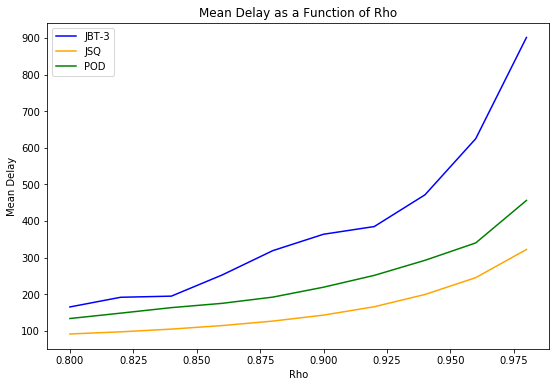

In [55]:
import math
from random import sample, random 
from collections import defaultdict
import numpy as np
import matplotlib.pylab as plt
import statistics as s

n = 10000 # number of samples
Nse= 20 # number of servers
# for jj in range(1,N + 1)
T0 = 1 # unit time 
Ymed = 10 # mean of Y
q  = 3/5 # probability
ET = T0 + (1-q)*Ymed #mean of T
alfa = 1/2

# generating the random [0,1] numbers for each simulation
R1 = [random() for _ in range(n)]
R2 = [random() for _ in range(n)]
R3 = [random() for _ in range(n)]
    
Tv = []
for i in range(n):
    if R1[i] <= q :
        Tv.append(T0)
    else:
        Tv.append(round(T0-Ymed*math.log(R2[i])))

def POD(queue):
    """ randomly sample the queue lengths of 3 servers and join the shortest (waiting time) among them """
    s = sample(list(queue.keys()),3)
    argmin = {s[0]:queue[s[0]],s[1]:queue[s[1]], s[2]:queue[s[2]] }
    return min(argmin, key=argmin.get)

def JSQ(queue):
    """ select the server with the shortest queue """
    return min(queue, key=queue.get)

def update_status(thr, idList, queueLengths):
    s1, s2, s3 = [server for server in sample(range(Nse), 3)] # select 3 servers at random          
    thr = min(queueLengths[s1], queueLengths[s2], queueLengths[s3])  # take the shortest queue as new threashold
    if thr == 0:
        thr = 1
    idList = [server for server in range(1,Nse+1) if queueLengths[server-1] < thr]  # update idList with the indexes of the servers having queue length shorter than the threashold
    return thr, idList

def JBTd(queue, idList):
    if len(idList) == 0:
        # in the case that no queue is below the threashold, choose a random server
        return sample(range(1,Nse+1), 1)[0]
    else:
        # if there are some queue with lenght below the throashold, then choose a server among them
        return sample(idList, 1)[0]

delayJSQ = defaultdict()
delayPOD = defaultdict()
delayJBT = defaultdict() # DICTIONARY TO PUT THE VALUE OF RHO AND THE ACCORDING AVERAGE DELAY
for rho in np.arange(0.8, 1, 0.02):
    rho = round(rho,2) 
    print(rho)   
    EX = rho*Nse*ET # calculate E[X] according to rho
    beta = EX/math.gamma(1+(1/alfa)) # beta accordinng to ex
    Xv = []
    wtJSQ, wtPOD, wtJBT = 0, 0, 0 # delay
    queueJSQ = defaultdict(int) # waiting time at server i
    queuePOD = defaultdict(int)
    queueJBT = defaultdict(int)
    for i in range(1,Nse+1):
        queueJSQ[i] = 0
        queuePOD[i] = 0
        queueJBT[i] = 0
    time = 0 # time counter
    
    """ Variables used only in JBT-d """
    thr = 1 # starting threshold
    idList = [i for i in range(1,Nse+1)] # list of server's Ids whose queue is below the threashold (all of them at the beginning since they all start empty)
    queueLengths = [0]*Nse # store the length of each queue
    idTasksForQueue = defaultdict(int) # store job id
    for i in range(1,Nse+1):
        idTasksForQueue[i] = []
            
    """ Start simulating for the given rho """
    for jc in range(n):
        Xv.append(max(1,min(100*EX,round(beta*(-math.log(R3[jc]))**(1/alfa))))) # simulations of Xv
        time += Tv[jc] # add the time that pass when there was not arrivals
        
        # JBT: Every 100 events update the threshold and the idList in the dispatcher
        if jc % 1000 == 0:
            thr, idList = update_status(thr, idList, queueLengths)
        
        # update the queues
        for i in range(1,Nse+1):
            queueJSQ[i] -= Tv[jc]
            queuePOD[i] -= Tv[jc]
            queueJBT[i] -= Tv[jc]
            if len(idTasksForQueue[i]) > 0: # remove from the queue all the tasks that are already compleated
                task = idTasksForQueue[i][0]
                ex_time = Xv[task]
                while (Tv[jc] - ex_time > 0) & (queueLengths[i-1] >0):
                    idTasksForQueue[i] = idTasksForQueue[i][1:]
                    queueLengths[i-1] -= 1
                    if len(idTasksForQueue[i]) > 0:                        
                        task = idTasksForQueue[i][0]                
                        ex_time += Xv[task]
                        
            if (queueJBT[i] < 0):
                queueJBT[i] = 0
                idTasksForQueue[i] = []
                queueLengths[i-1] = 0
            if (queueJSQ[i] <0):
                queueJSQ[i] = 0
            if (queuePOD[i] <0):
                queuePOD[i] = 0
        
        snJSQ = JSQ(queueJSQ)
        queueJSQ[snJSQ] += Xv[jc]
        wtJSQ += queueJSQ[snJSQ]
        
        snPOD = POD(queuePOD)
        queuePOD[snPOD] += Xv[jc]
        wtPOD += queuePOD[snPOD]
        
        
        snJBT = JBTd(queueJBT, idList) # sn in range(1,21)
        queueLengths[snJBT-1] += 1
        idTasksForQueue[snJBT].append(jc)
        queueJBT[snJBT] += Xv[jc]        
        wtJBT += queueJBT[snJBT]
        idList = [server for server in range(1,Nse+1) if queueLengths[server-1] < thr]
        jc += 1
    
    delayJSQ[rho] = wtJSQ/jc
    delayPOD[rho] = wtPOD/jc
    delayJBT[rho] = wtJBT/jc
    print(s.mean(Xv),s.stdev(Xv),min(Xv),max(Xv))
%matplotlib inline
plt.figure(figsize=(9,6))
listJBT = sorted(delayJBT.items()) # sorted by key, return a list of tuples
xJBT, yJBT = zip(*listJBT) # unpack a list of pairs into two tuples
plt.plot(xJBT, yJBT, label = "JBT-3", c='blue')

listJSQ = sorted(delayJSQ.items()) # sorted by key, return a list of tuples
xJSQ, yJSQ = zip(*listJSQ) # unpack a list of pairs into two tuples
plt.plot(xJSQ, yJSQ, label = "JSQ",c='orange')

listPOD = sorted(delayPOD.items()) # sorted by key, return a list of tuples
xPOD, yPOD = zip(*listPOD) # unpack a list of pairs into two tuples
plt.plot(xPOD, yPOD, label = "POD", c='green')
plt.xlabel("Rho")
plt.ylabel("Mean Delay")
plt.title('Mean Delay as a Function of Rho')
plt.legend()
plt.show()

# Message overhead

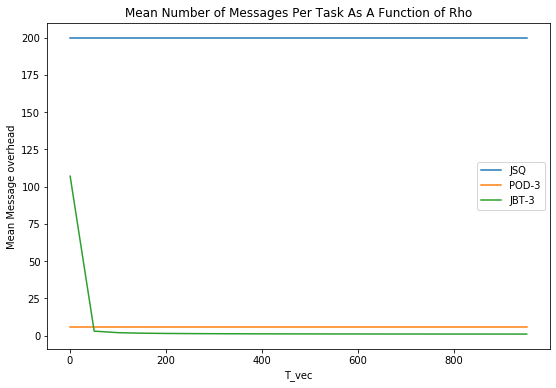

In [51]:
import numpy as np
import matplotlib.pylab as plt

N = 100 # number of servers
d = 3

def messageOverheadJSQ(T,N):
    return 2*N

def messageOverheadPOD(T,d):
    return 2*d

def messageOverheadJBT(T,N,d):
    return 1 + (N+2*d)/T

T_vec = np.arange(1,1000,50)
JSQ_vec = [messageOverheadJSQ(T, N) for T in T_vec]
POD_vec = [messageOverheadPOD(T, d) for T in T_vec]
JBT_vec = [messageOverheadJBT(T, N, d) for T in T_vec]
%matplotlib inline
plt.figure(figsize=(9,6))
plt.plot(T_vec, JSQ_vec, label = 'JSQ')
plt.plot(T_vec, POD_vec, label = 'POD-3')
plt.plot(T_vec, JBT_vec, label = 'JBT-3')
plt.xlabel('T_vec')
plt.ylabel('Mean Message overhead')
plt.title('Mean Number of Messages Per Task As A Function of Rho')
plt.legend()